In [1]:
import json
import pandas as pd
from utils import preprocessing, set_index
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from dc_vae_continual import DCVAE, Sampling
from utils import samples_conditions_embedd
import pickle
from statsmodels.graphics.tsaplots import plot_acf

2023-06-18 18:24:45.906616: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Settings

In [2]:
settings_path = 'settings/model_settings_continual_J2_transpose.txt'
settings = json.load(open(settings_path, 'r'))
print(settings)

{'dataset_name': 'TELCO', 'model_name': 'dc-vae_continual_J2_transpos', 'scale': False, 'wo_outliers': True, 'max_std': 7, 'T': 16, 'M': 12, 'cnn_units': [64, 128, 128, 128], 'dil_rate': [1, 2, 4, 8], 'kernel': 2, 'strs': 1, 'activation': 'selu', 'alpha_reg': 0.0001, 'batch_size': 64, 'J': 2, 'epochs': 200, 'lr': 0.001, 'lr_decay': False, 'decay_rate': 0.96, 'decay_step': 7000, 'val_percent': 0.2, 'time_embedding': False, 'summary': True, 'save_best_model': False, 'save_complete_model': True}


### Train data

In [3]:

#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames_train = ["TELCO_data_2021_01.zip", "TELCO_data_2021_02.zip", "TELCO_data_2021_03.zip",
                "TELCO_data_2021_04.zip", "TELCO_data_2021_05.zip", "TELCO_data_2021_06.zip",
                "TELCO_data_2021_07.zip", "TELCO_data_2021_08.zip", "TELCO_data_2021_09.zip",
                "TELCO_data_2021_10.zip", "TELCO_data_2021_11.zip", "TELCO_data_2021_12.zip"]
files_train = [path+ i for i in filenames_train]

# Load data and predictions
# Read CSV files from List
data_train = pd.concat(map(pd.read_csv, files_train))
data_train = set_index(data_train)
data_train = preprocessing(data_train, flag_scaler=False, outliers=True)
data_train.head()

TS1       TS2       TS3       TS4       TS5  \
time                                                                    
2021-01-01 00:00:00  0.790423  0.572709  0.576859  0.786895  0.845216   
2021-01-01 00:05:00  0.774003  0.540110  0.576859  0.794884  0.843063   
2021-01-01 00:10:00  0.743711  0.532618  0.762395  0.809906  0.826144   
2021-01-01 00:15:00  0.768127  0.517837  0.762395  0.751709  0.834179   
2021-01-01 00:20:00  0.734526  0.495463  0.517999  0.664537  0.908283   

                          TS6       TS7       TS8       TS9  TS10      TS11  \
time                                                                          
2021-01-01 00:00:00  0.655201  0.723233  0.795858  0.407110  0.80  0.008386   
2021-01-01 00:05:00  0.717850  0.560724  0.650888  0.407110  0.80  0.008386   
2021-01-01 00:10:00  0.639912  0.530483  0.618343  0.407110  0.80  0.008386   
2021-01-01 00:15:00  0.641776  0.538414  0.603550  0.103483  0.45  0.001316   
2021-01-01 00:20:00  1.184732  0.501817  0.568047  0.103483  0.45  0.001316   

                         TS12  
time                           
2021-01-01 00:00:00  0.010724  
2021-01-01 00:05:00  0.010724  
2021-01-01 00:10:00  0.010724  
2021-01-01 00:15:00  0.008043  
2021-01-01 00:20:00  0.008043

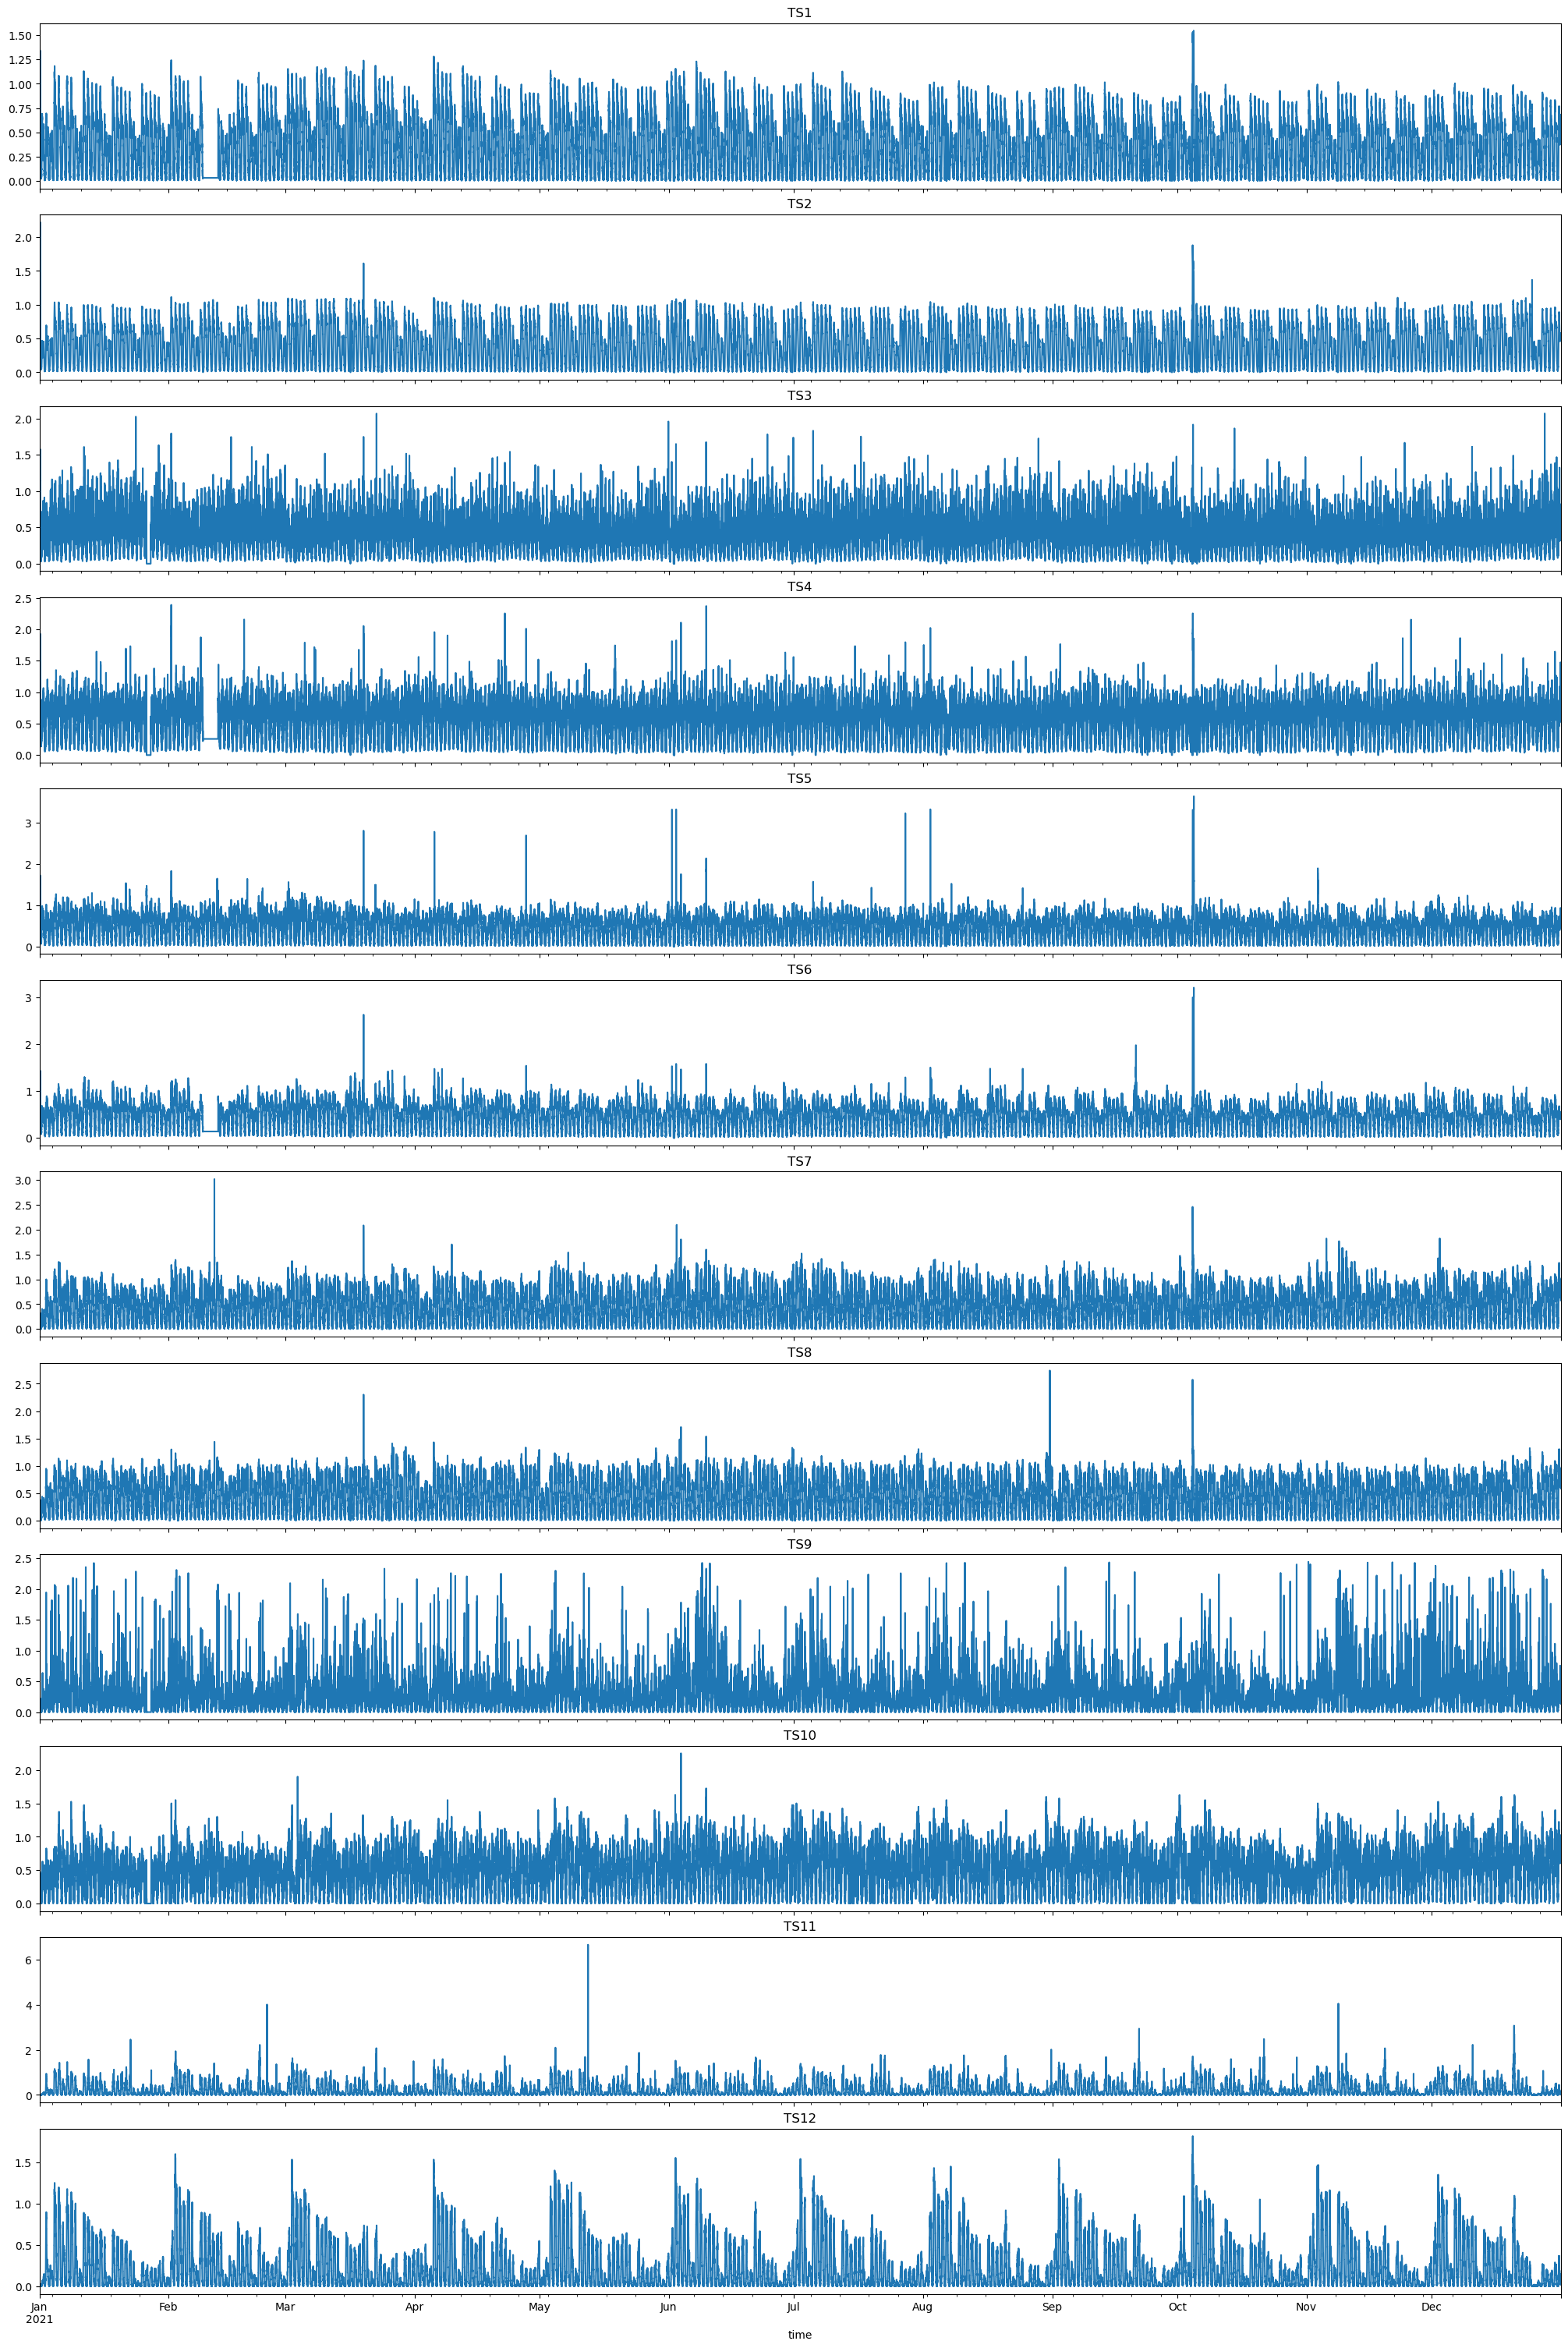

In [4]:
#define number of rows and columns for subplots
nrow=12
ncol=1

columns_list = data_train.columns

time_start = '2021-01-01'
time_end = '2021-12-31'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_train[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].set_title(columns_list[count])
        count+=1

### Test data

In [5]:
#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames_test = ["TELCO_data_2022_01.zip", "TELCO_data_2022_02.zip", "TELCO_data_2022_03.zip", "TELCO_data_2022_04.zip"]
files_test = [path+ i for i in filenames_test]

In [6]:
# Load data and predictions
# Read CSV files from List
data_test = pd.concat(map(pd.read_csv, files_test))
data_test = set_index(data_test)
data_test = preprocessing(data_test, flag_scaler=False, outliers=True)
data_test.head()

TS1       TS2       TS3       TS4       TS5  \
time                                                                    
2022-01-01 00:00:00  0.648864  0.505284  0.669942  0.837027  0.623184   
2022-01-01 00:05:00  0.649752  0.497994  0.669942  0.820139  0.580578   
2022-01-01 00:10:00  0.593288  0.476937  0.704539  0.777010  0.643936   
2022-01-01 00:15:00  0.544374  0.467724  0.704539  0.835551  0.570099   
2022-01-01 00:20:00  0.611489  0.443933  0.516019  0.795907  0.523654   

                          TS6       TS7       TS8       TS9   TS10      TS11  \
time                                                                           
2022-01-01 00:00:00  0.535870  0.634853  0.668639  0.247535  0.875  0.021380   
2022-01-01 00:05:00  0.441524  0.590735  0.582840  0.247535  0.875  0.021380   
2022-01-01 00:10:00  0.459797  0.548041  0.520710  0.247535  0.875  0.021380   
2022-01-01 00:15:00  0.418404  0.556218  0.523669  0.151931  0.575  0.014328   
2022-01-01 00:20:00  0.401623  0.632546  0.588757  0.151931  0.575  0.014328   

                         TS12  
time                           
2022-01-01 00:00:00  0.021448  
2022-01-01 00:05:00  0.021448  
2022-01-01 00:10:00  0.021448  
2022-01-01 00:15:00  0.016086  
2022-01-01 00:20:00  0.016086

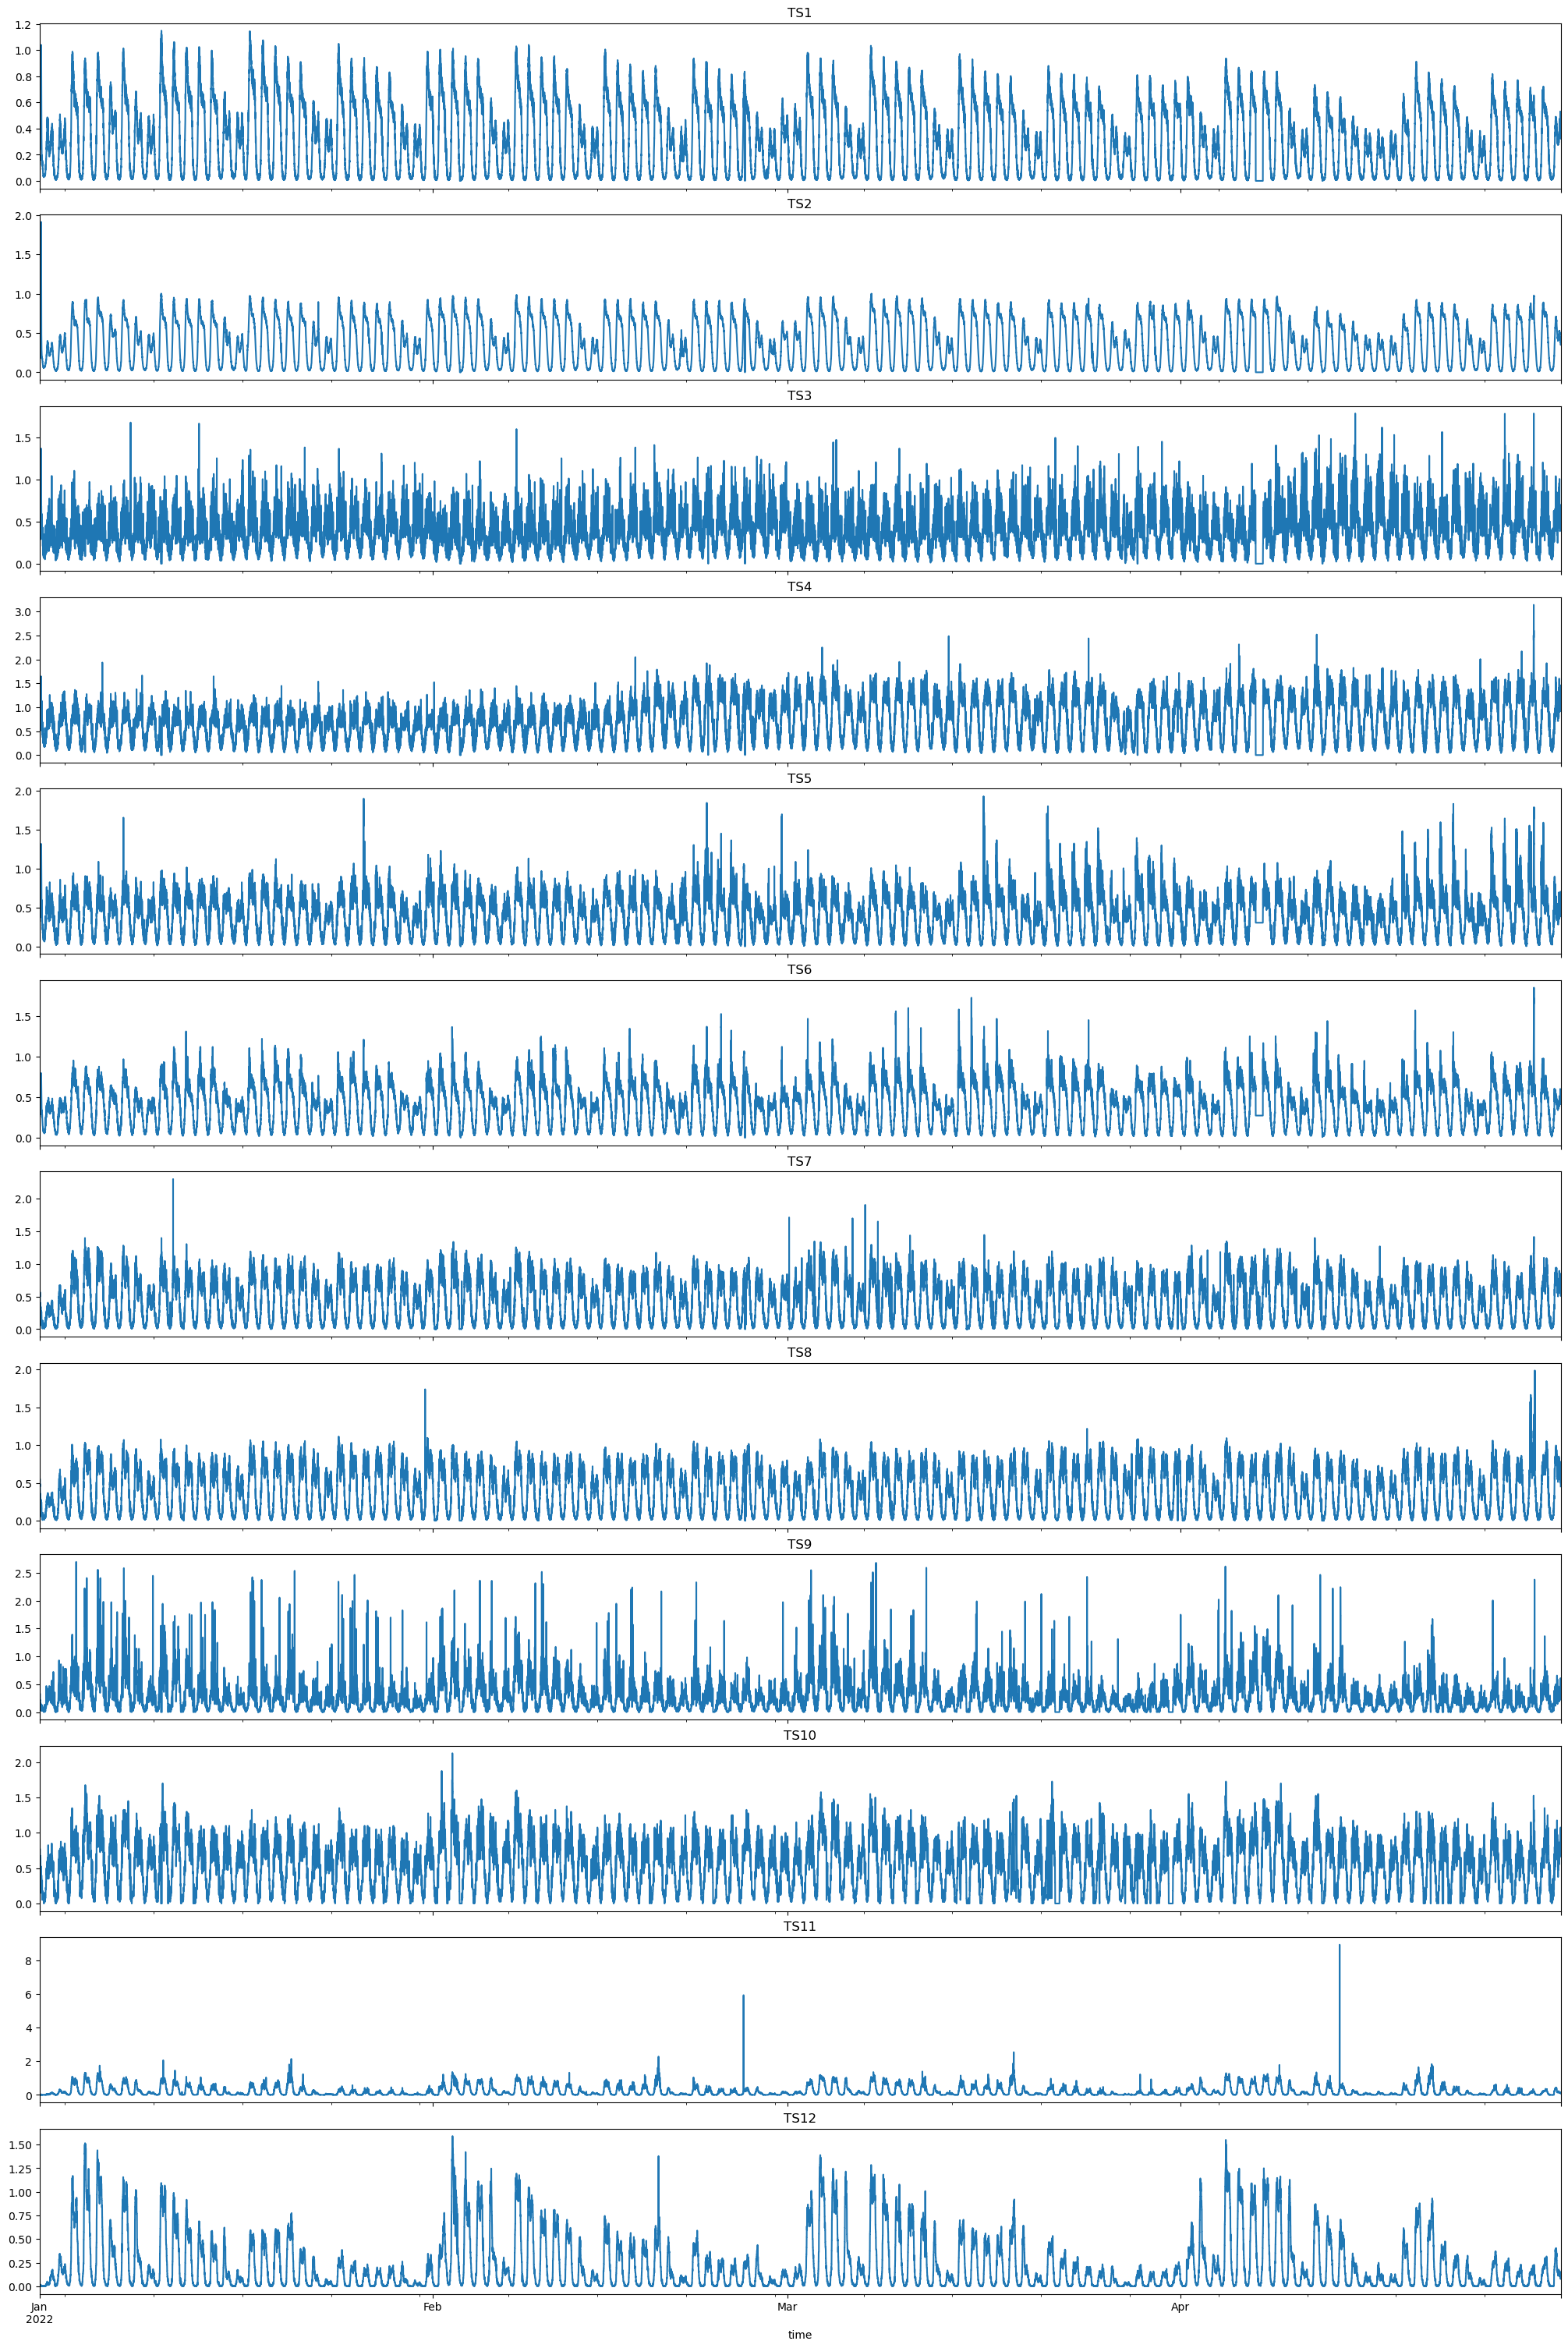

In [7]:
#define number of rows and columns for subplots
nrow=12
ncol=1

columns_list = data_test.columns

time_start = '2022-01-01'
time_end = '2022-04-30'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_test[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].set_title(columns_list[count])
        count+=1

## Predicciones

In [8]:
# Model initialization
model = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['time_embedding'],
    settings['summary'],
    ) 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-06-18 18:25:08.053876: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-18 18:25:08.054673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-18 18:25:08.064662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 18:25:08.064790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-06-18 18:25:08.064810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-18 18:25:08.066024: I tensorflow/stream_executor/platform/default/d

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 16, 12)]     0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 16, 64)       1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 16, 128)      16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 16, 128)      32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [9]:
anom_train, error_train, reconst_train, sig_train, latent_space = model.predict(data_train,
                                        True,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]
                                                    )
th_up_train = reconst_train + sig_train
th_down_train = reconst_train - sig_train

2023-06-18 18:25:09.341470: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-18 18:25:09.341787: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz
2023-06-18 18:25:09.566160: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-18 18:25:10.028334: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-18 18:25:10.091149: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-06-18 18:25:10.663813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


**Series reales con las predicciones de media y sigma**

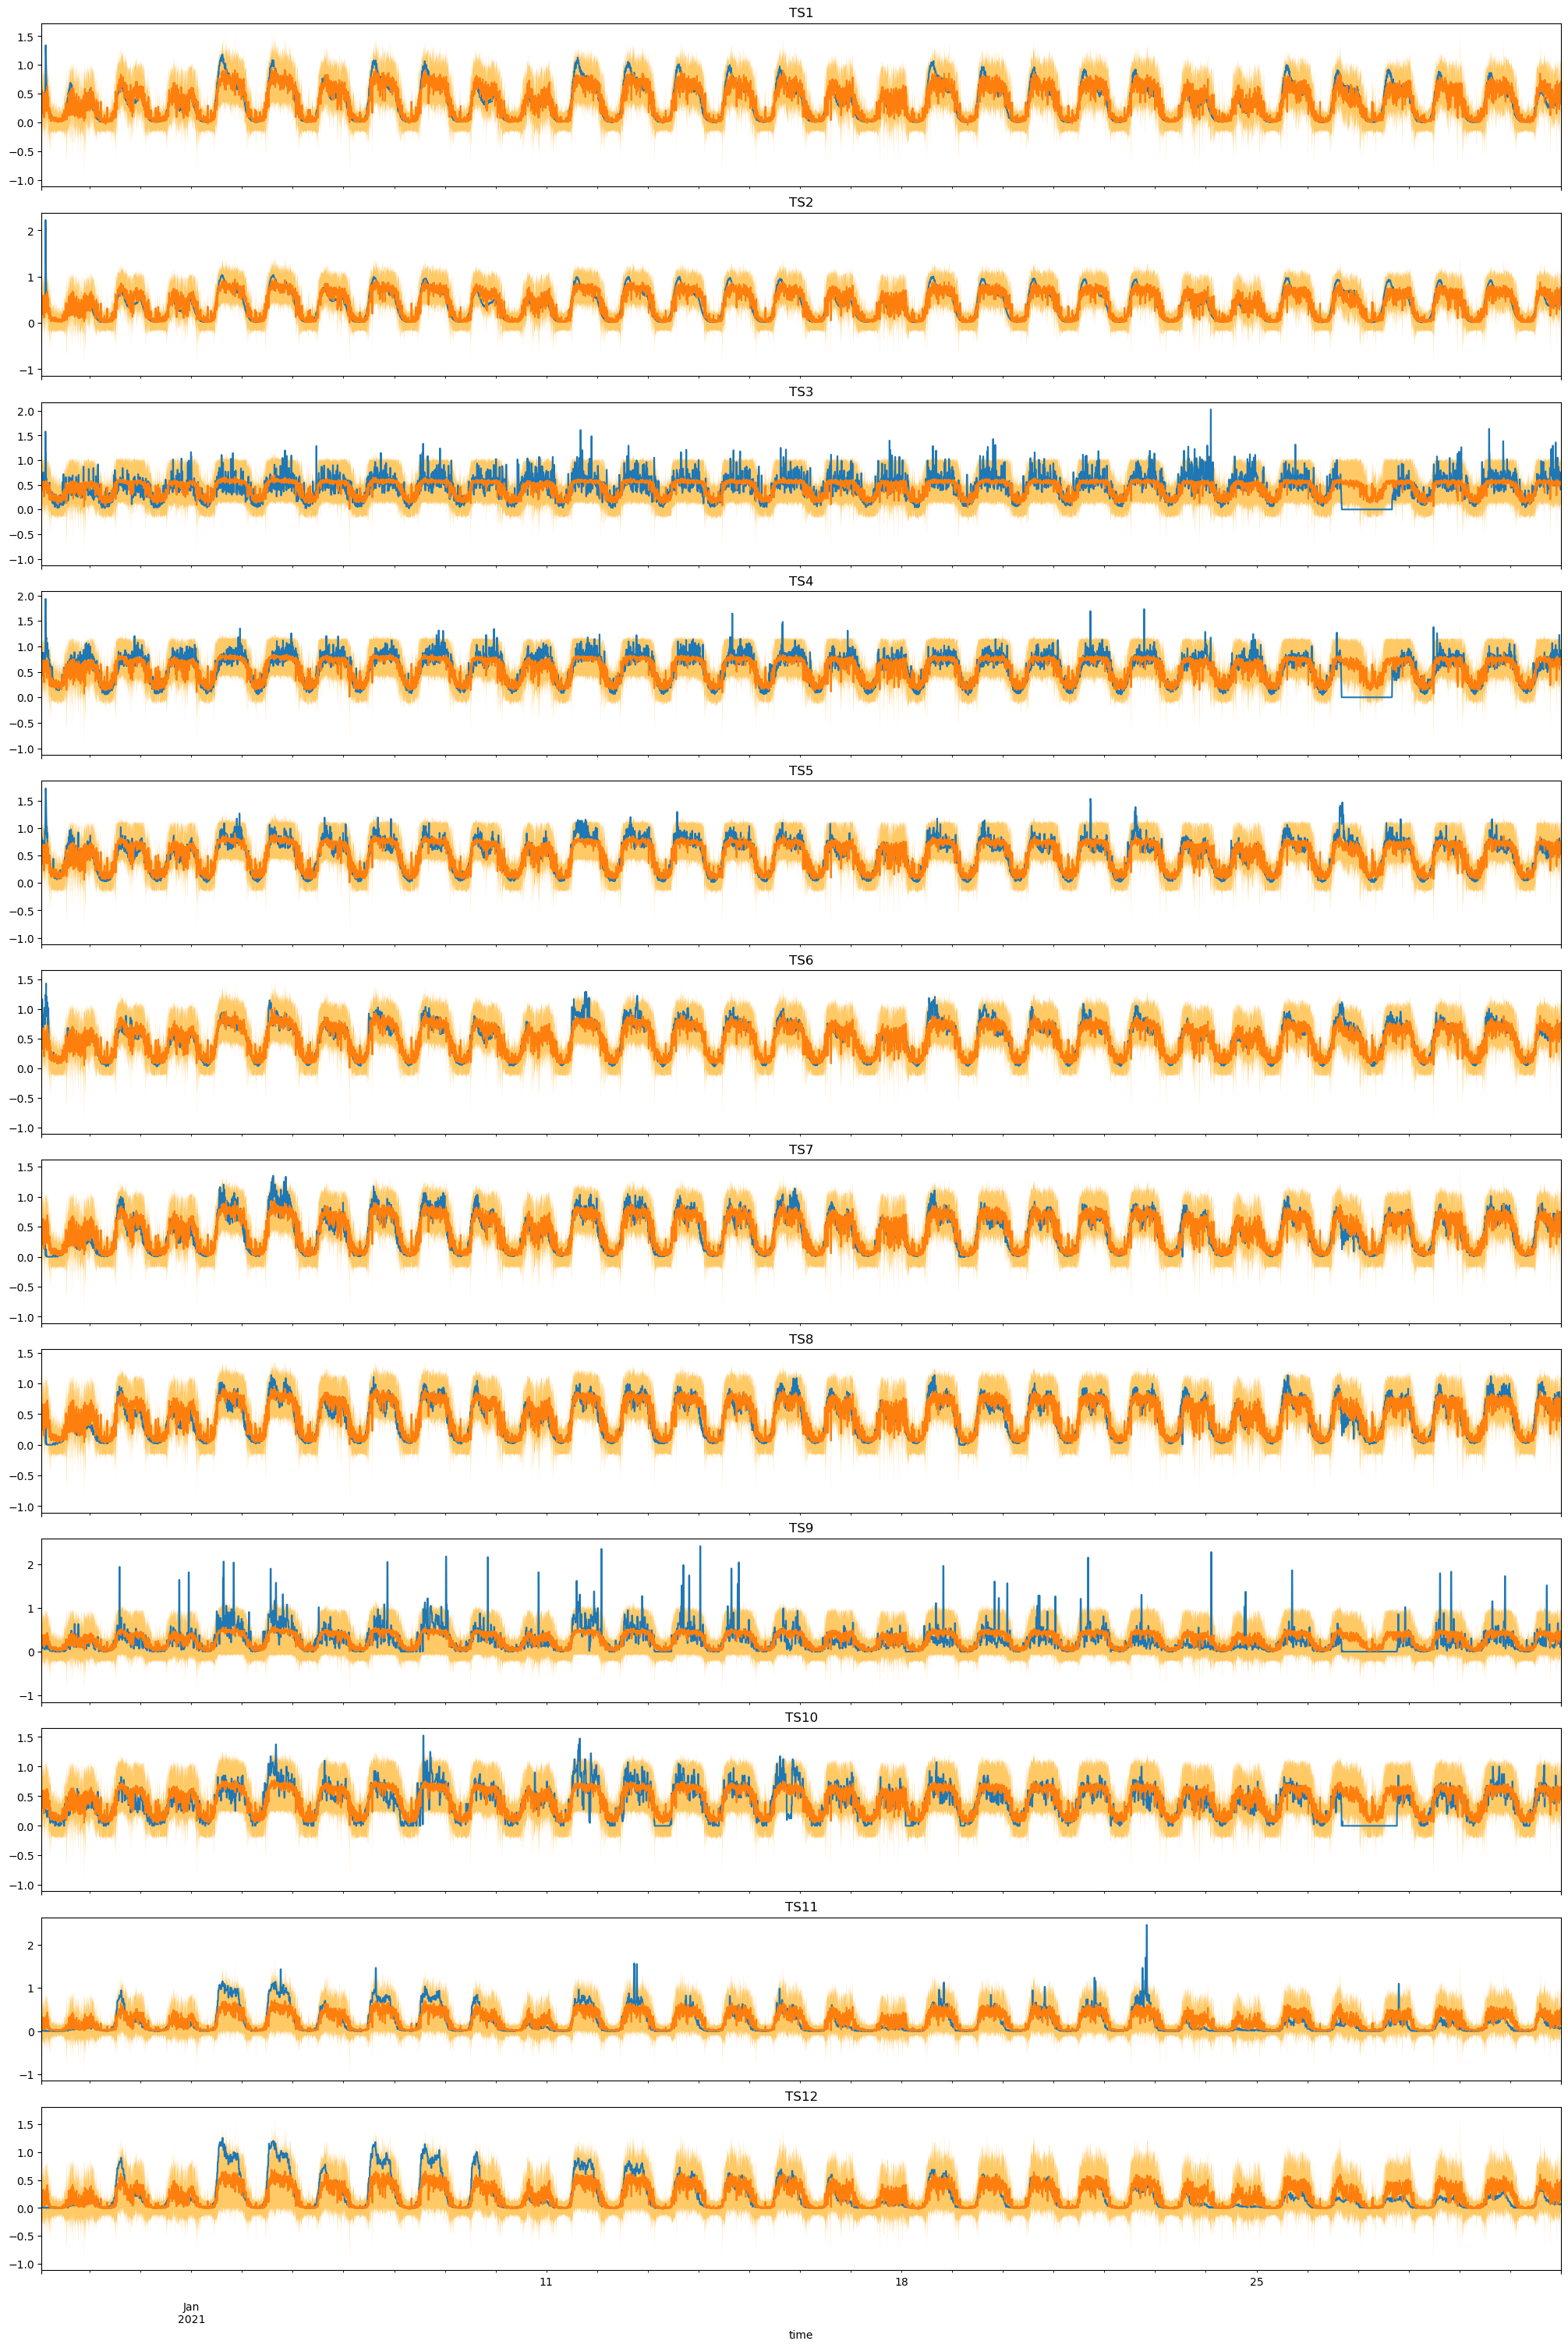

In [10]:
#define number of rows and columns for subplots
nrow=12
ncol=1
data_aux = data_train[reconst_train.index[0]:].copy()

columns_list = data_aux.columns

time_start = '2021-01-01'
time_end = '2021-01-30'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_aux[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        reconst_train[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].fill_between(data_aux[columns_list[count]][time_start:time_end].index,
                         th_up_train[columns_list[count]][time_start:time_end],
                         th_down_train[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.6, interpolate=True)
        axes[r].set_title(columns_list[count])
        count+=1

In [11]:
anom_test, error_test, reconst_test, sig_test, latent_space = model.predict(data_test,
                                        True,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]
                                                    )
th_up_test = reconst_test + sig_test
th_down_test = reconst_test - sig_test

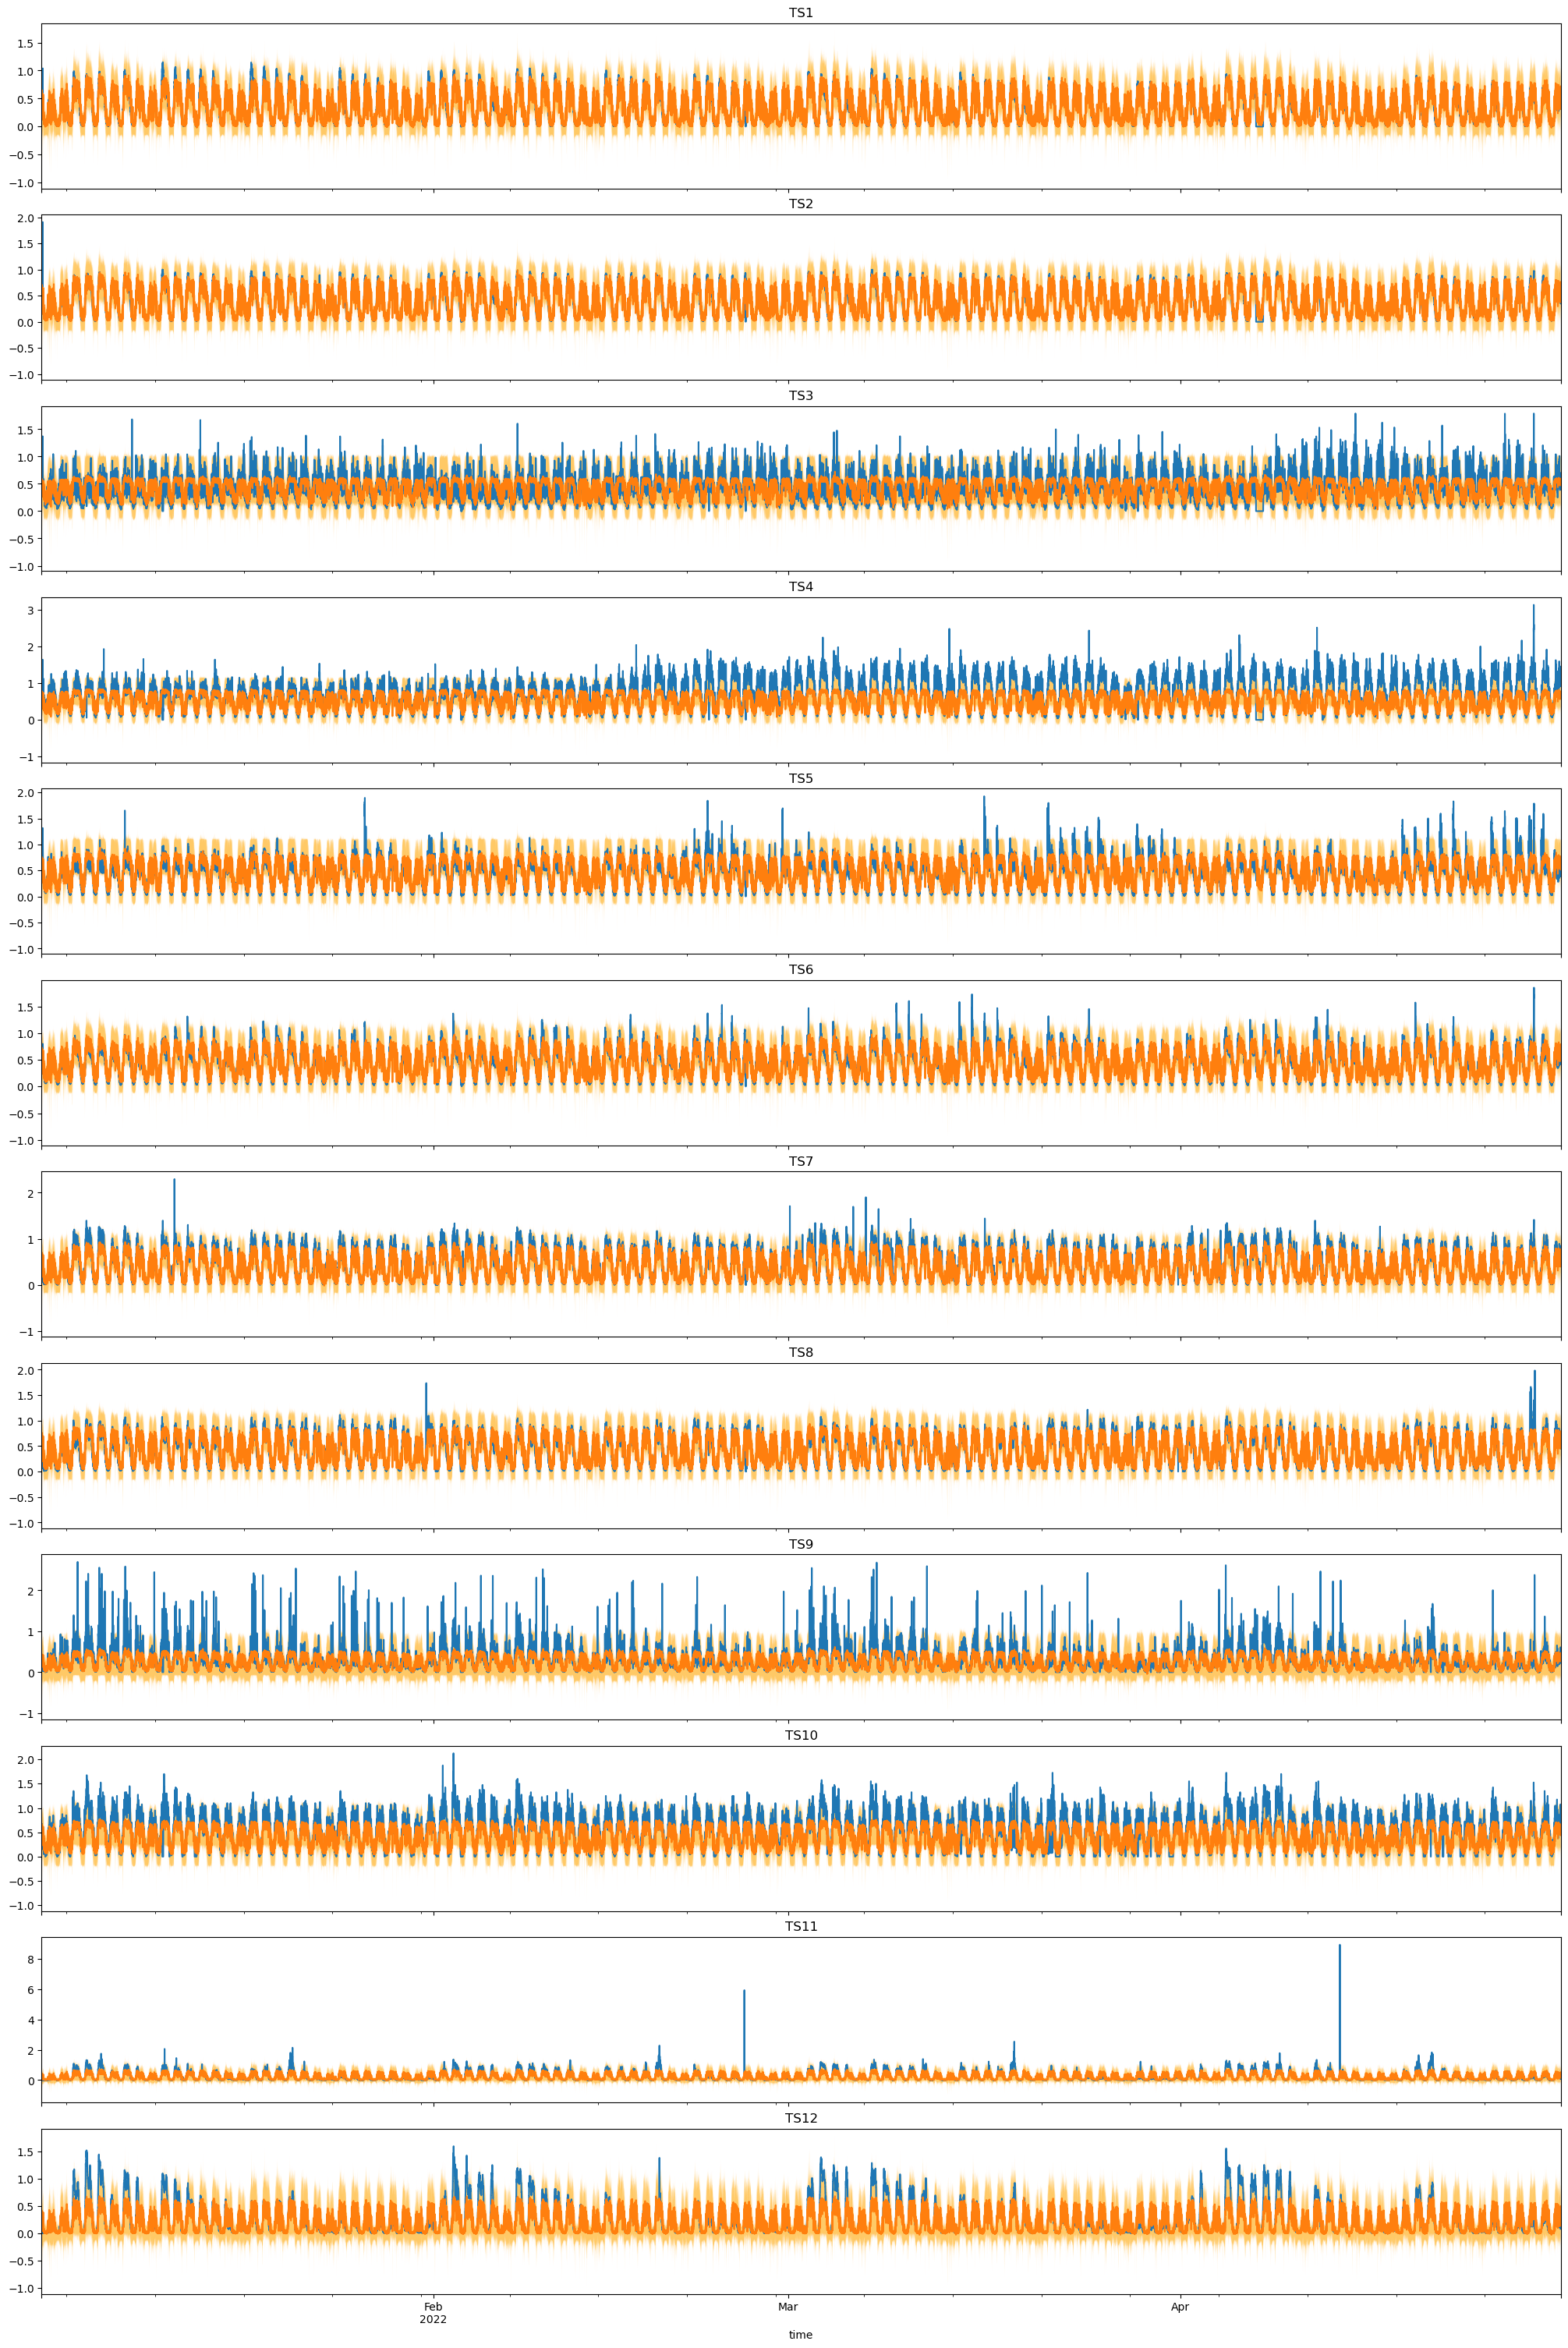

In [12]:
#define number of rows and columns for subplots
nrow=12
ncol=1
data_aux = data_test[reconst_test.index[0]:].copy()

columns_list = data_aux.columns

time_start = '2022-01-01'
time_end = '2022-04-30'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_aux[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        reconst_test[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].fill_between(data_aux[columns_list[count]][time_start:time_end].index,
                         th_up_test[columns_list[count]][time_start:time_end],
                         th_down_test[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.6, interpolate=True)
        axes[r].set_title(columns_list[count])
        count+=1

## Espacio de latencia

In [13]:
if settings["time_embedding"]:
    X, time_info = samples_conditions_embedd(data_train, settings["T"])  
    input_samples_train = (X, time_info)
else:
    X = data_train.values
    N = data_train.shape[0]
    X = np.array([X[i: i + settings["T"]] for i in range(0, N - settings["T"]+1)])
    input_samples_train = X

z_mu_train, z_log_var_train, z_train = model.encoder.predict(input_samples_train)
z_sig_train = np.exp(0.5*z_log_var_train)

### Ejemplo de como se agrupan los puntos por hora

### $\mu_z$

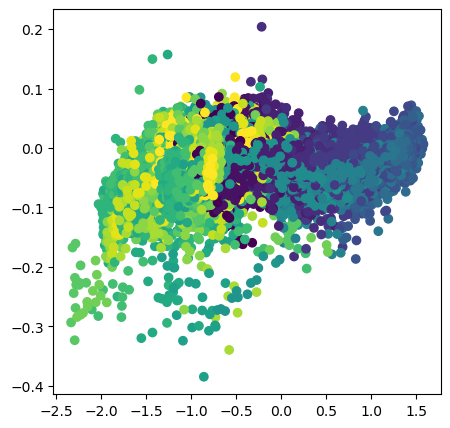

In [14]:
plt.figure(figsize=(5,5))

plt.scatter(z_mu_train[:, -1, 0], z_mu_train[:, -1, 1], 
                          c=data_train[settings['T']-1:].index.hour[:])

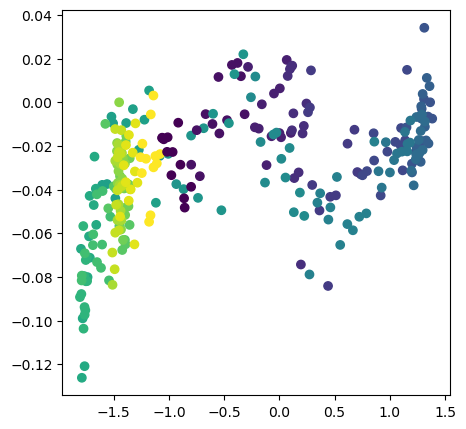

In [15]:
plt.figure(figsize=(5,5))

day_number = 288
count = 4

plt.scatter(z_mu_train[count*day_number:(count+1)*day_number, -1, 0], 
                          z_mu_train[count*day_number:(count+1)*day_number, -1, 1], 
                          c=data_train.index.hour[(settings['T']-1)+count*day_number:(settings['T']-1)+(count+1)*day_number])

### $\sigma_z$

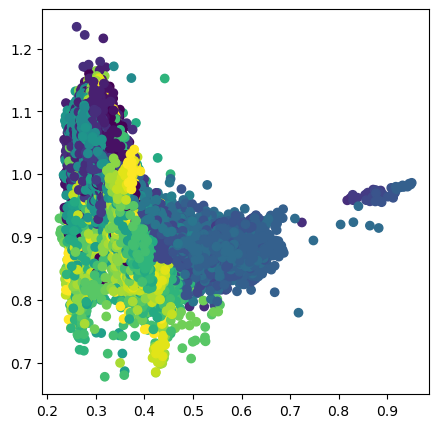

In [16]:
plt.figure(figsize=(5,5))

plt.scatter(z_sig_train[:, -1, 0], z_sig_train[:, -1, 1], 
                          c=data_train[settings['T']-1:].index.hour[:])

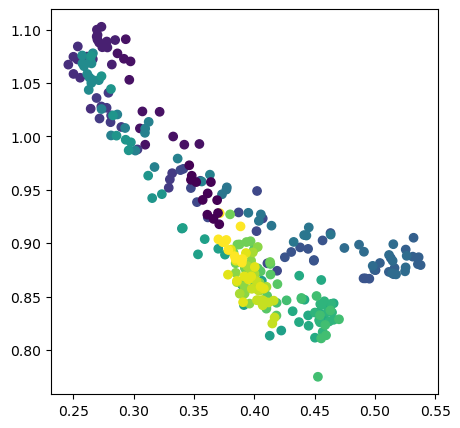

In [17]:
plt.figure(figsize=(5,5))

day_number = 288
count = 4

plt.scatter(z_sig_train[count*day_number:(count+1)*day_number, -1, 0], 
                          z_sig_train[count*day_number:(count+1)*day_number, -1, 1], 
                          c=data_train.index.hour[(settings['T']-1)+count*day_number:(settings['T']-1)+(count+1)*day_number])

### $z$

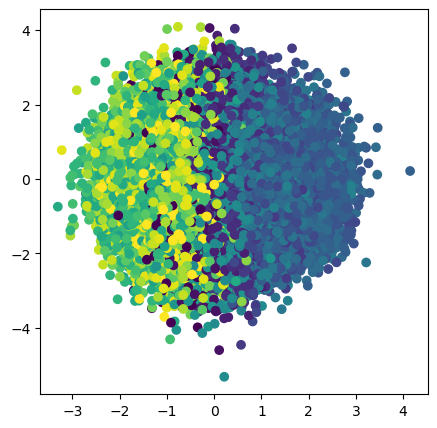

: 

In [18]:
plt.figure(figsize=(5,5))

plt.scatter(z_train[:, -1, 0], z_train[:, -1, 1], 
                          c=data_train[settings['T']-1:].index.hour[:])